# Blackbird Rotation Angles

The overall rotation angles is given by the camera system but the rates for quaternions can be estimated from the gryoscope values from the IMU.

In [1]:
import os
import sys
sys.path.append(os.path.abspath('../functions'))
import read_blackbird_dataset as rbd

test_df = rbd.read_blackbird_test('figure8', 'Constant', 0.5)

In [2]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216365 entries, 1526617312016142000 to 1526617526753759000
Data columns (total 37 columns):
PWM1                              39823 non-null float64
PWM2                              39823 non-null float64
PWM3                              39823 non-null float64
PWM4                              39823 non-null float64
angular_velocity_covariance       21298 non-null object
ax_[m/s2]                         21298 non-null float64
ay_[m/s2]                         21298 non-null float64
az_[m/s2]                         21298 non-null float64
linear_acceleration_covariance    21298 non-null object
omegax_[dps]                      21298 non-null float64
omegay_[dps]                      21298 non-null float64
omegaz_[dps]                      21298 non-null float64
orientation_covariance            21298 non-null object
pitch_[rad]                       77286 non-null float64
pitch_ref_[rad]                   38130 non-null float64
px_[m]

In [3]:
import numpy as np

rbts2s = 10 ** -9
rtd = 180.0/np.pi

subset_df = test_df[['qw','qx','qy','qz',\
                  'roll_[rad]', 'pitch_[rad]', 'yaw_[rad]']]

subset_df = subset_df.dropna()
tvec = (subset_df.index - subset_df.index[0])*rbts2s
tvec = tvec.astype('float')


<IPython.core.display.Javascript object>


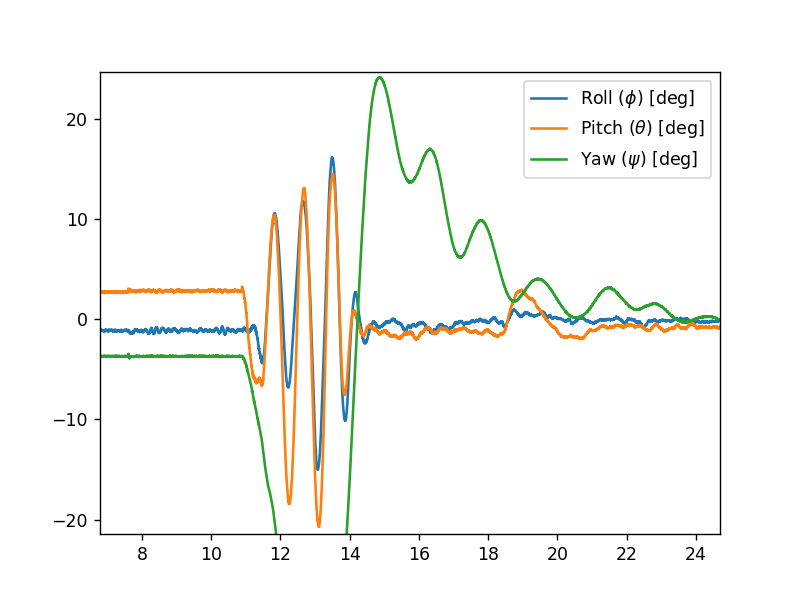

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)

ax.plot(tvec, subset_df['roll_[rad]']*rtd, label="Roll ($\phi$) [deg]")
ax.plot(tvec, subset_df['pitch_[rad]']*rtd, label="Pitch ($\\theta$) [deg]")
ax.plot(tvec, subset_df['yaw_[rad]']*rtd, label="Yaw ($\psi$) [deg]")

plt.legend()

plt.show()

<IPython.core.display.Javascript object>


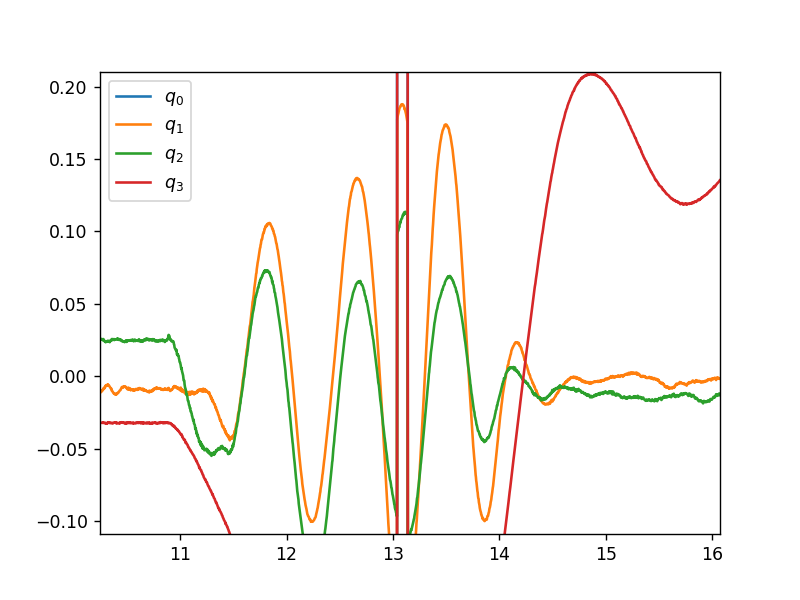

In [5]:
fig, ax = plt.subplots(1,1)

ax.plot(tvec, subset_df['qw'].values, label="$q_0$")
ax.plot(tvec, subset_df['qx'].values, label="$q_1$")
ax.plot(tvec, subset_df['qy'].values, label="$q_2$")
ax.plot(tvec, subset_df['qz'].values, label="$q_3$")

plt.legend()
plt.show()

In [9]:
def quaternion_solution_check(qn1, qn):
    """
    Summary: Returns most likely quaternion solution between the positive rotation angle and is negative rotation angle. 
    Metric to decide is the minimization of the L2 norm.
    
    Parameters:
        * q is a quaternion of [q0, q1, q2, q3] in a list
        * qn1 is the previous timestep quaternion
        * qn is the current timestep quaternion
    """
    #Make opposite quaternion
    neg_qn = [-1*qi for qi in qn]
    
    #Scoring based off L2 norm since update rate is so high
    sp = 0
    sn = 0
    for qn1_i, qn_i, neg_qn_i in zip(qn1, qn, neg_qn):
        sp += (qn1_i - qn_i) ** 2
        sn += (qn1_i - neg_qn_i) ** 2
    #Return most likely
    if sn < sp:
        return neg_qn
    else:
        return qn

print(quaternion_solution_check([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5]))
print(quaternion_solution_check([0.5, 0.5, 0.5, 0.5], [-0.5, -0.5, -0.5, -0.5]))
print(quaternion_solution_check([0.5, 0.5, 0.5, 0.5], [0.5, -0.5, -0.5, 0.5]))

[0.5, 0.5, 0.5, 0.5]
[0.5, 0.5, 0.5, 0.5]
[0.5, -0.5, -0.5, 0.5]


In [ ]:
from dsp import central_sg_filter as sgf

q3coeff = sgf(tvec, xvec, m=5, window=25)
